<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/Gold_price_Tme_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [63]:
#data_pd=pd.read_csv("/content/Gold_Prices.csv")
data_pd=pd.read_csv("/content/Hasbros_Stock_History.csv")

In [64]:
data_pd.head()

,Day,Price
0,1,0.10535
1,2,0.09877
2,3,0.10974
3,4,0.10755
4,5,0.10535


In [65]:
data_np=data_pd.to_numpy()

In [66]:
data_np

array([[1.0000e+00, 1.0535e-01],
       [2.0000e+00, 9.8770e-02],
       [3.0000e+00, 1.0974e-01],
       ...,
       [1.0214e+04, 7.8510e+01],
       [1.0215e+04, 8.0410e+01],
       [1.0216e+04, 7.9910e+01]])

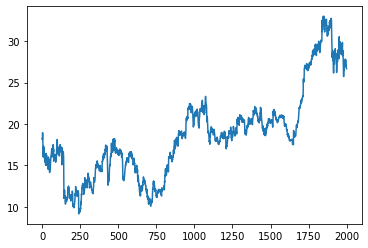

In [67]:
plt.plot(data_np[5000:7000,1])

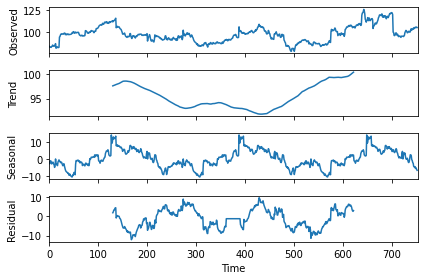

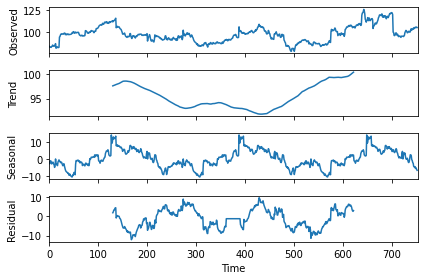

In [68]:
decomp=seasonal_decompose(data_np[9283:10036,1],freq=261,model='additive')
decomp.plot()

In [69]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [70]:
time=data_np[:8000,0]
series=data_np[:8000,1]
split_time = 6000
train_time=time[:split_time]
valid_time=time[split_time:]
train_series=series[:split_time]
valid_series=series[split_time:]

In [71]:
window_size=100
train_data=window_dataset(train_series,window_size)
valid_data=window_dataset(valid_series,window_size)

In [72]:
keras.backend.clear_session()

In [73]:
model=tf.keras.Sequential([tf.keras.layers.Dense(1,input_shape=[window_size])])

In [74]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),loss=keras.losses.Huber(),metrics=["mae"])

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1001      
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.fit(train_data,epochs=100,validation_data=valid_data)

Epoch 1/100
157/157 [==============================] - 3s 19ms/step - loss: 9.9076 - mae: 10.3729 - val_loss: 67.4330 - val_mae: 67.9330
Epoch 2/100
157/157 [==============================] - 3s 20ms/step - loss: 13.2363 - mae: 13.7186 - val_loss: 2.2120 - val_mae: 2.6732
Epoch 3/100
157/157 [==============================] - 3s 20ms/step - loss: 11.1998 - mae: 11.6732 - val_loss: 69.6964 - val_mae: 70.1964
Epoch 4/100
157/157 [==============================] - 3s 20ms/step - loss: 8.9080 - mae: 9.3685 - val_loss: 41.3557 - val_mae: 41.8557
Epoch 5/100
157/157 [==============================] - 3s 20ms/step - loss: 9.0215 - mae: 9.4793 - val_loss: 5.0357 - val_mae: 5.5081
Epoch 6/100
157/157 [==============================] - 3s 20ms/step - loss: 12.7556 - mae: 13.2288 - val_loss: 30.3501 - val_mae: 30.8501
Epoch 7/100
157/157 [==============================] - 3s 20ms/step - loss: 12.3574 - mae: 12.8313 - val_loss: 102.7395 - val_mae: 103.2395
Epoch 8/100
157/157 [====================

In [77]:
def model_forecast(model,series,window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(size=window_size, shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  lin_forecast=model.predict(dataset)
  return lin_forecast

In [78]:
#lin_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)
lin_forecast=model_forecast(model,data_np[8000-window_size:-1,1],window_size)

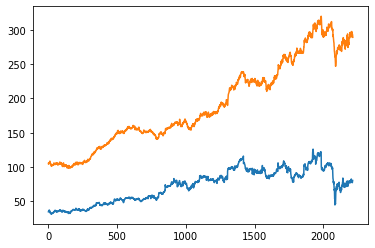

In [79]:
#plt.plot(valid_time,valid_series)
#plt.plot(valid_time,lin_forecast)
plt.plot(data_np[8000:-1,1])
plt.plot(lin_forecast)
plt.show()

In [89]:
lin_forecast

array([[105.23956],
       [104.06217],
       [104.52407],
       ...,
       [292.54257],
       [291.4637 ],
       [289.07892]], dtype=float32)

# Reinforcement Learning:

In [80]:
initial_data=data_np[7000-window_size:7000,1]

In [81]:
initial_data=data_np[7000-window_size:7000,1]
rein_data=initial_data
pred_rein=np.zeros(3100,dtype=float)
for i in range(0,3100):
  rein_forecast=model_forecast(model,rein_data,window_size)
  rein_data=np.append(rein_data[1:],rein_forecast)
  pred_rein[i]=rein_forecast
  

In [82]:
pred_rein

array([7.14326019e+01, 8.22890015e+01, 9.64110107e+01, ...,
       2.38547986e+37, 2.44789771e+37, 2.51194905e+37])

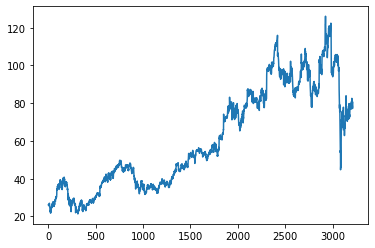

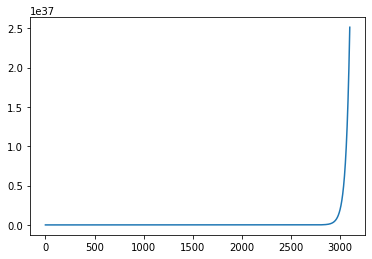

In [88]:
plt.clf()
plt.plot(data_np[7000:-1,1])
plt.show()
plt.plot(pred_rein)
plt.show()

In [86]:
model_forecast(model,initial_data,window_size)

array([[71.4326]], dtype=float32)

In [85]:
ini

NameError: ignored